In [1]:
from utils import *
from similarity_utils import *
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

c:\Users\mpronesti\AppData\Local\anaconda3\envs\bpmn\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [12]:
#all_files = load_bpmn_files_from_random_folders("cleaned_data", subset_size=4)
#V_k08 = 'cleaned_data\\V_k08'
#G_j01 = 'cleaned_data\\G_j01'

all_files = load_bpmn_files_from_specific_folder("cleaned_data\R_j03")

files_info = build_process_info_dict(all_files, model)
#similarity = get_2ProcessesSimilarity(files_info[all_files[0]], files_info[all_files[1]])

all_files_similarity_matrix = get_AllFilesSimilarityMatrix(files_info)
#plot_AllFilesSimilarityMatrix(all_files_similarity_matrix, all_files)

<>:5: SyntaxWarning: invalid escape sequence '\R'
<>:5: SyntaxWarning: invalid escape sequence '\R'
C:\Users\mpronesti\AppData\Local\Temp\ipykernel_16320\3728715971.py:5: SyntaxWarning: invalid escape sequence '\R'
  all_files = load_bpmn_files_from_specific_folder("cleaned_data\R_j03")


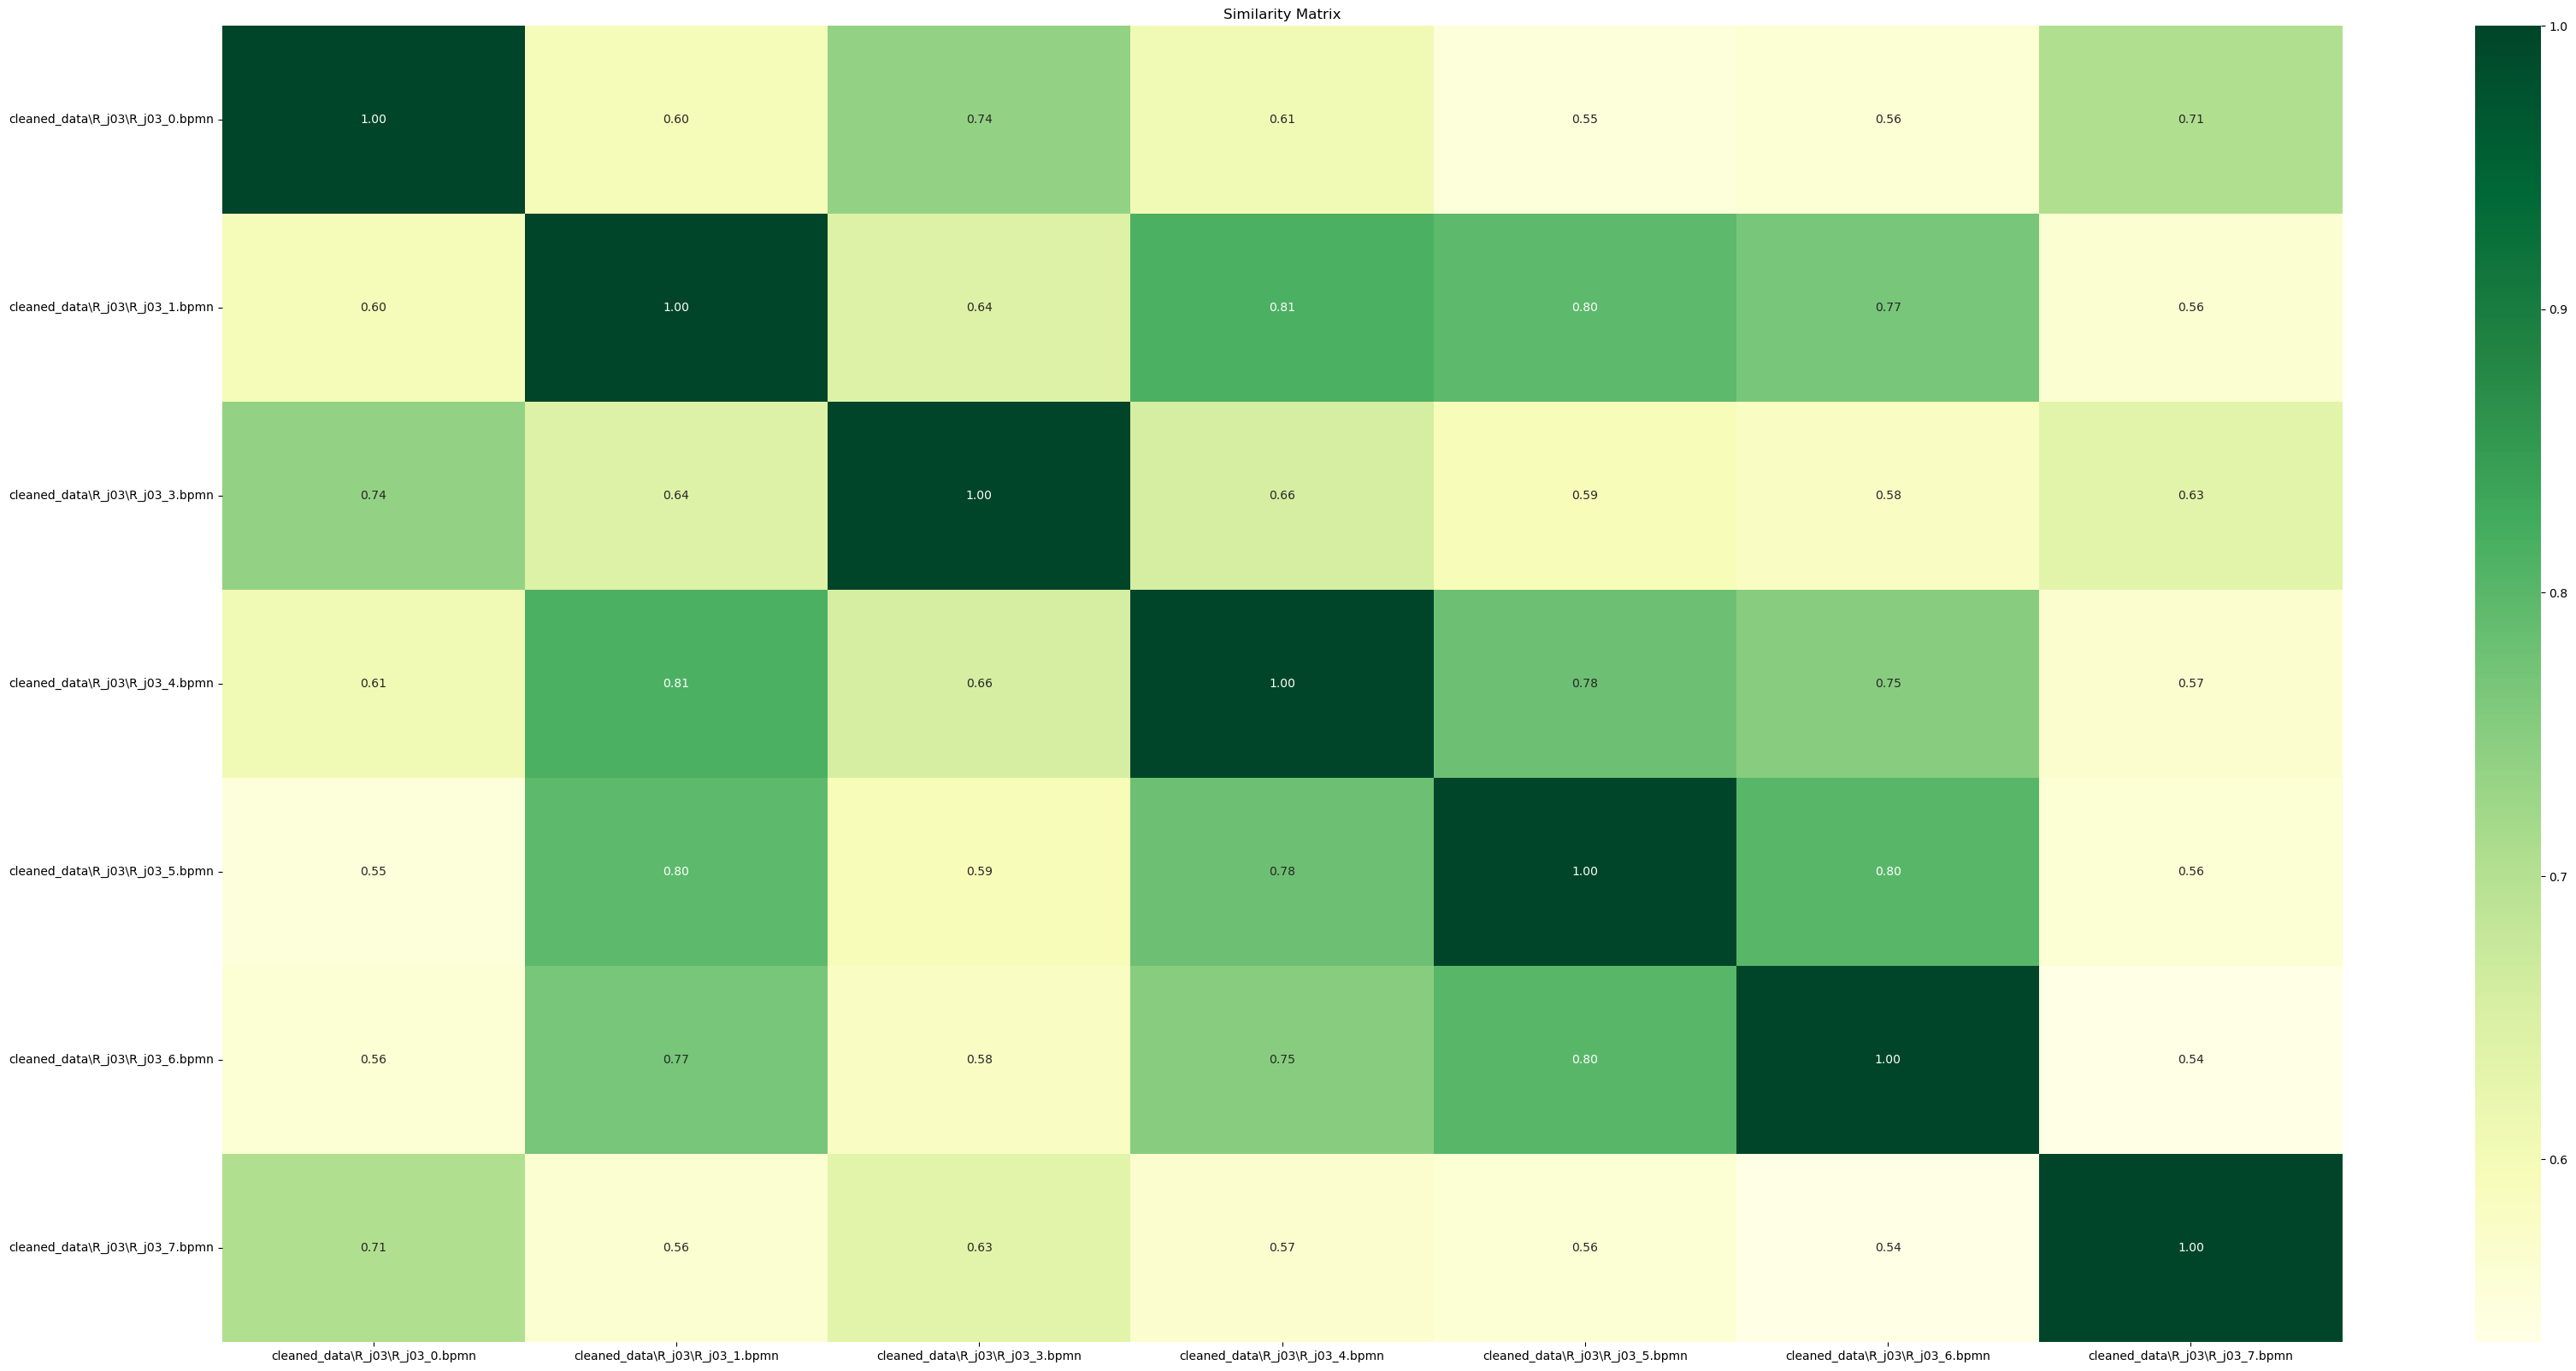

In [13]:
# Plot the similarity matrix
plt.figure(figsize=(40, 20))
sns.heatmap(all_files_similarity_matrix, annot=True, fmt=".2f", cmap='YlGn', xticklabels=all_files, yticklabels=all_files)
plt.title("Similarity Matrix")
plt.show()